In [22]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath(".."))
from src.config import Config
from src.backtest import Backtester
from src.backtest_min import BacktesterMin

config = Config()

In [11]:
TOKEN = config.get("TINKOFF_TOKEN")  # берём токен из переменной окружения

In [23]:
from tinkoff.invest import Client
import os

with Client(TOKEN) as client:
    instruments = client.instruments.shares().instruments
    for share in instruments:
        if share.ticker == "SBER":  # ищем Сбербанк
            print(share.figi, share.name)
            FIGI = share.figi

BBG004730N88 Сбер Банк


In [ ]:
from tinkoff.invest import Client, CandleInterval
from datetime import datetime, timedelta
import pandas as pd
import os            # FIGI для Сбербанка

def load_candles(figi: str, days: int = 365) -> pd.DataFrame:
    """
    Загружаем дневные свечи по FIGI за последние N дней.
    """
    end = datetime.utcnow()
    start = end - timedelta(days=days)

    with Client(TOKEN) as client:
        candles = client.market_data.get_candles(
            figi=figi,
            from_=start,
            to=end,
            interval=CandleInterval.CANDLE_INTERVAL_DAY
        )

    data = []
    for c in candles.candles:
        data.append({
            "date": c.time,
            "open": c.open.units + c.open.nano / 1e9,
            "high": c.high.units + c.high.nano / 1e9,
            "low": c.low.units + c.low.nano / 1e9,
            "close": c.close.units + c.close.nano / 1e9,
            "volume": c.volume
        })

    df = pd.DataFrame(data)
    df = df.sort_values("date").reset_index(drop=True)
    return df

/var/folders/72/b7x6pblx55l7d1bw9rtw10fc0000gq/T/ipykernel_17111/2332084895.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow()


                       date    open    high     low   close    volume
0 2024-04-29 00:00:00+00:00  309.14  309.60  307.65  308.97  10025690
1 2024-04-30 00:00:00+00:00  309.19  309.49  308.03  308.24   5980690
2 2024-05-02 00:00:00+00:00  308.70  309.19  306.80  307.37  16262520
3 2024-05-03 00:00:00+00:00  307.11  308.29  304.34  307.53  30466990
4 2024-05-06 00:00:00+00:00  308.10  308.10  305.55  306.01  19203550
Метрики стратегии:
        CAGR: -0.1004
  Volatility: 0.1643
      Sharpe: -0.5617
     Sortino: -0.0019
       MaxDD: -0.2638
     Winrate: 0.6667
Final Equity: 848556.6303


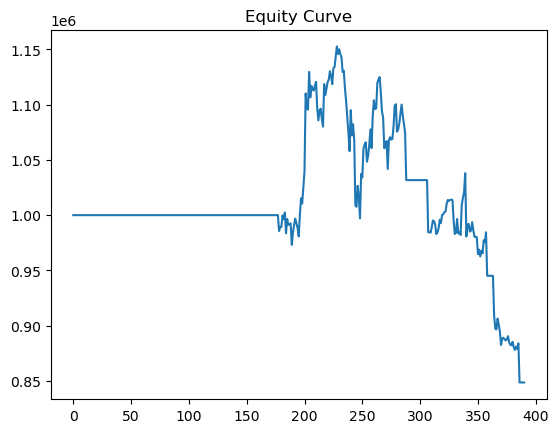

In [31]:
# 1. Получаем данные
df = load_candles(FIGI, days=500)  # например, 500 последних дней
print(df.head())

# 2. Генерируем простые сигналы (SMA-кросс)
fast, slow = 20, 100
df["sma_fast"] = df["close"].rolling(fast).mean()
df["sma_slow"] = df["close"].rolling(slow).mean()
signals = (df["sma_fast"] > df["sma_slow"]).astype(int)  # 1 = long, 0 = flat

# 3. Запускаем бэктест
bt = Backtester(df, commission = 0.04, slippage=0.00003)
result = bt.run(signals)

print("Метрики стратегии:")
for k, v in result.stats.items():
    print(f"{k:>12}: {v:.4f}")

# 4. Рисуем equity curve
import matplotlib.pyplot as plt
result.equity_curve.plot(title="Equity Curve")
plt.show()

## 1 MIN

In [21]:
from tinkoff.invest import Client, CandleInterval
from datetime import datetime, timedelta
import pandas as pd
import os

def load_minute_candles(figi: str, days: int = 5) -> pd.DataFrame:
    """
    Загружаем минутные свечи по FIGI за последние N дней.
    """
    end = datetime.utcnow()
    start = end - timedelta(days=days)

    all_candles = []

    with Client(TOKEN) as client:
        current = start
        while current < end:
            next_day = current + timedelta(days=1)
            candles = client.market_data.get_candles(
                figi=figi,
                from_=current,
                to=next_day,
                interval=CandleInterval.CANDLE_INTERVAL_1_MIN
            )
            for c in candles.candles:
                all_candles.append({
                    "date": c.time,
                    "open": c.open.units + c.open.nano / 1e9,
                    "high": c.high.units + c.high.nano / 1e9,
                    "low": c.low.units + c.low.nano / 1e9,
                    "close": c.close.units + c.close.nano / 1e9,
                    "volume": c.volume
                })
            current = next_day

    df = pd.DataFrame(all_candles)
    df = df.sort_values("date").reset_index(drop=True)
    return df

In [27]:
df = load_minute_candles(FIGI, 300)

/var/folders/72/b7x6pblx55l7d1bw9rtw10fc0000gq/T/ipykernel_17111/3158925013.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow()


Метрики стратегии:
        CAGR: -1.0000
  Volatility: 1.7492
      Sharpe: -44.2669
     Sortino: -0.0002
       MaxDD: -1.0000
     Winrate: 0.3313
Final Equity: 0.0000


<Axes: title={'center': 'Equity Curve (1m data)'}>

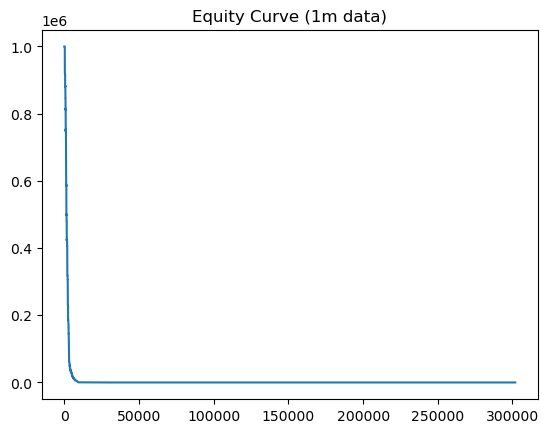

In [28]:
# допустим, у нас есть df с минутками (load_minute_candles)
df["sma_fast"] = df["close"].rolling(20).mean()
df["sma_slow"] = df["close"].rolling(100).mean()
signals = (df["sma_fast"] > df["sma_slow"]).astype(int)

bt = BacktesterMin(df, commission=0.04, slippage=0.00003, bars_per_year=97500)
result = bt.run(signals)

print("Метрики стратегии:")
for k, v in result.stats.items():
    print(f"{k:>12}: {v:.4f}")

result.equity_curve.plot(title="Equity Curve (1m data)")

# Backtesting lib

In [55]:
import os
from datetime import datetime, timedelta

import pandas as pd
from tinkoff.invest import Client, CandleInterval
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA


def load_candles(figi: str, days: int = 200, interval=CandleInterval.CANDLE_INTERVAL_DAY) -> pd.DataFrame:
    """
    Загружаем свечи с Tinkoff Invest API и возвращаем DataFrame для backtesting.py
    """
    end = datetime.utcnow()
    start = end - timedelta(days=days)

    with Client(TOKEN) as client:
        candles = client.market_data.get_candles(
            figi=figi,
            from_=start,
            to=end,
            interval=interval
        )

    data = []
    for c in candles.candles:
        data.append({
            "Date": c.time,
            "Open": c.open.units + c.open.nano / 1e9,
            "High": c.high.units + c.high.nano / 1e9,
            "Low": c.low.units + c.low.nano / 1e9,
            "Close": c.close.units + c.close.nano / 1e9,
            "Volume": c.volume,
        })

    df = pd.DataFrame(data)
    df = df.sort_values("Date").reset_index(drop=True)
    df.set_index("Date", inplace=True)  # backtesting.py требует индекс по времени
    return df



In [64]:
df = load_candles(FIGI, days=365 * 2, interval=CandleInterval.CANDLE_INTERVAL_DAY)
print(df.head())

/var/folders/72/b7x6pblx55l7d1bw9rtw10fc0000gq/T/ipykernel_17111/4236298551.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow()


                             Open    High     Low   Close    Volume
Date                                                               
2023-09-11 00:00:00+00:00  257.00  258.37  255.16  256.25  43344230
2023-09-12 00:00:00+00:00  257.70  262.40  257.09  262.40  45160410
2023-09-13 00:00:00+00:00  262.40  262.77  257.59  258.18  30051360
2023-09-14 00:00:00+00:00  258.90  261.38  255.02  260.00  46227900
2023-09-15 00:00:00+00:00  259.65  262.74  258.56  260.83  35581630


In [74]:
class SmaCross(Strategy):
    fast = 20
    slow = 100

    def init(self):
        close = self.data.Close
        self.sma_fast = self.I(SMA, close, self.fast)
        self.sma_slow = self.I(SMA, close, self.slow)

    def next(self):
        if crossover(self.sma_fast, self.sma_slow):
            self.buy(size=0.8)
        elif crossover(self.sma_slow, self.sma_fast):
            self.sell(size=0.8)

        # if crossover(self.sma_fast, self.sma_slow):
        #     self.buy(size=10)   # вместо "всё депо"
        # elif crossover(self.sma_slow, self.sma_fast):
        #     self.sell(size=10)


In [75]:
class RiskManagedSmaCross(Strategy):
    fast = 50
    slow = 100
    risk_per_trade = 0.01  # 1% капитала

    def init(self):
        close = self.data.Close
        self.sma_fast = self.I(SMA, close, self.fast)
        self.sma_slow = self.I(SMA, close, self.slow)

    def next(self):
        price = self.data.Close[-1]

        # Закрываем позицию, если SMA пересеклись в другую сторону
        if crossover(self.sma_slow, self.sma_fast):
            self.position.close()

        # Вход в лонг
        elif crossover(self.sma_fast, self.sma_slow):
            if not self.position:  # только если позиции нет
                # стоп-лосс под локальным минимумом (или на 2% ниже цены)
                stop = price * 0.98  
                risk_amount = self.equity * self.risk_per_trade
                trade_risk = price - stop

                # размер позиции = сколько акций купить при риске 1%
                size = risk_amount // trade_risk  

                if size > 0:
                    self.buy(size=size, sl=stop)

In [76]:
bt = Backtest(df, SmaCross, cash=1_000_000, commission=.0004)
stats = bt.run()
print(stats)
bt.plot()

Backtest.run:   0%|          | 0/453 [00:00<?, ?bar/s]

Start                     2023-09-11 00:00...
End                       2025-09-10 00:00...
Duration                    730 days 00:00:00
Exposure Time [%]                    44.84629
Equity Final [$]                 982206.93206
Equity Peak [$]                  1195801.3017
Commissions [$]                     224.44452
Return [%]                           -1.77931
Buy & Hold Return [%]                12.91036
Return (Ann.) [%]                    -0.81479
Volatility (Ann.) [%]                12.48875
CAGR [%]                             -0.61784
Sharpe Ratio                         -0.06524
Sortino Ratio                        -0.08912
Calmar Ratio                         -0.03761
Alpha [%]                             4.33052
Beta                                 -0.47325
Max. Drawdown [%]                   -21.66687
Avg. Drawdown [%]                    -3.96575
Max. Drawdown Duration      288 days 00:00:00
Avg. Drawdown Duration       40 days 00:00:00
# Trades                          

/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:966: UserWarning: time=526: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/var/folders/72/b7x6pblx55l7d1bw9rtw10fc0000gq/T/ipykernel_17111/1841235001.py:2: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:709: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:709: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p5207', ...)